# DrEyeBot Retinal Image Analysis using CNN

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import datetime
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import imutils
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.utils.multiclass import unique_labels
from shutil import copyfile

import pandas as pd
import cv2
import seaborn as sn

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
from keras.models import Sequential,Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import model_from_json
from keras import applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.initializers import glorot_normal


from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop,SGD
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#from pyimagesearch.smallervggnet import SmallerVGGNet

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8387759290732008593
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3222305881645340831
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14999196234727271191
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15560753152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17469881969139110198
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


## Common Functions

### Helper Functions

In [4]:
def levelset(x):
    """ Sets Levels 1-4 to level 1"""
    if x>0:
        return 1
    else:
        return 0

def RMSE(actual, predict):
    diff = actual - predict
    diff = sum(diff**2) / len(actual)
    return np.sqrt(diff)

def select_toy_images(image_label,N=-1,images_percent=list()):
    """ Selects number of images from each class. By default it is ALL images"""
    image_list = list()
    final_images = pd.DataFrame(columns = image_label.columns)
    # We create a toy dataset of 'N' images, maintaining the split of the original 
    if N==-1:
            # We need to pick all the images. No need to sample
            # We can ignore the percentage here
            final_images = image_label
    else:
        for level in range(5):
        # Get respective number of images in each level
            if len(images_percent)==5:
                number_of_images = int(images_percent[level]*N/100)
            else:
                # We have no percentage of images. Setting the default safe percentage
                images_percent = [73.6,6.9,15.1,2.4,2]
                number_of_images = int(images_percent[level]*N/100)
            sample_images = image_label[image_label.level==level].sample(n=number_of_images,axis=0)
            frames = [final_images,sample_images]
            final_images = pd.concat(frames).reset_index(drop=True)
    return final_images 

def preprocess(image,scale=224):
    """ preprocess the test image and covert to array """
    inter=cv2.INTER_AREA
    (h, w) = image.shape[:2]
    dW = 0
    dH = 0

    width = scale
    height = scale

    # if the width is smaller than the height, then resize
    # along the width (i.e., the smaller dimension) and then
    # update the deltas to crop the height to the desired
    # dimension
    if w < h:
        image = imutils.resize(image, width=width,
            inter=inter)
        dH = int((image.shape[0] - height) / 2.0)

    # otherwise, the height is smaller than the width so
    # resize along the height and then update the deltas
    # crop along the width
    else:
        image = imutils.resize(image, height=height,
            inter=inter)
        dW = int((image.shape[1] - width) / 2.0)

    # now that our images have been resized, we need to
    # re-grab the width and height, followed by performing
    # the crop
    (h, w) = image.shape[:2]
    image = image[dH:h - dH, dW:w - dW]

    # finally, resize the image to the provided spatial
    # dimensions to ensure our output image is always a fixed
    # size

    image =  cv2.resize(image, (width, height),
        interpolation=inter)
    return img_to_array(image)

def selector(x):
    """ Function to select the class"""
    if x[0] > x[1]:
        return 0
    else:
        return 1

### Model related functions

In [5]:
def VGG_16_TL(input_shape,layers_to_skip=None,weights=None,include_top=True):
    """ VGG 16 with Transfer Learning. Using Keras built in function"""
    model = applications.VGG16(weights = weights, include_top=include_top, input_shape = input_shape)
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final

def VGG_16(weights_path=None):
    initializer = glorot_normal()
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),input_shape=(length,width,depth),
                     activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu',kernel_initializer=initializer))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu',kernel_initializer=initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    #print(model.summary())
    return model

def CNN_FF():
    """ CNN with Feed Forward NN """
    model_conv = Sequential()
    model_conv.add(Conv2D(32, kernel_size=(5, 5), 
                                          input_shape=(length,width,depth),activation='relu'))
    model_conv.add(MaxPooling2D(pool_size=(2, 2)))
    model_conv.add(Conv2D(64, (5, 5), activation='relu'))
    model_conv.add(MaxPooling2D(pool_size=(2, 2)))
    model_conv.add(Flatten())
    model_conv.add(Dense(100))
    model_conv.add(Dropout(0.1))
    model_conv.add(Dense(num_classes, activation='softmax'))
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    model_conv.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    #print(model_conv.summary())
    return model_conv


def save_model(model,vgg=True):
    # saving model
    json_model = model.to_json()
    # Get today's date. We will use this as string for filename
    now = datetime.datetime.now()
    day = str(now)[:10]
    if vgg:
        arch_name = 'model_architecture_vgg_'+day+'35K_aug'+'.json'
        model_weights = 'model_weights_vgg_'+day+'35K_aug'+'.h5'
    else:
        arch_name = 'model_architecture_s_cnn'+day+'.json'
        model_weights = 'model_weights_s_cnn'+day+'.h5'
        
    open(arch_name, 'w').write(json_model)
    # saving weights
    model.save_weights(model_weights, overwrite=True)

def load_model():
    # loading model
    model = model_from_json(open('model_architecture.json').read())
    model.load_weights('model_weights.h5')
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

## LOAD DATA

In [6]:
# Load the csv data
orig_label = pd.read_csv("./Retinal-Images/trainLabels.csv")
# Load the test csv data
test_label = pd.read_csv("./Retinal-Images/retinopathy_solution.csv")
test_label.drop('Usage',inplace=True,axis=1)

In [7]:
orig_label.count()

image    35126
level    35126
dtype: int64

In [8]:
test_label.count()

image    53576
level    53576
dtype: int64

In [9]:
orig_label.groupby(['level']).count()

,image
level,
0,25810
1,2443
2,5292
3,873
4,708


In [10]:
test_label.groupby(['level']).count()

,image
level,
0,39533
1,3762
2,7861
3,1214
4,1206


### DATA PREPERATION

In [11]:
l4_orig_df = orig_label[orig_label.level==4].sample(200)
l3_orig_df = orig_label[orig_label.level==3].sample(500)
l2_orig_df = orig_label[orig_label.level==2].sample(500)
l1_orig_df = orig_label[orig_label.level==1].sample(500)
l0_orig_df = orig_label[orig_label.level==0].sample(3300)
rest_orig_df = pd.concat([orig_label, l4_orig_df,l3_orig_df,
                          l2_orig_df,l1_orig_df,l0_orig_df]).drop_duplicates(keep=False)
len(rest_orig_df)

30126

In [12]:
l4_test_df = test_label[test_label.level==4].sample(200)
l3_test_df = test_label[test_label.level==3].sample(500)
l2_test_df = test_label[test_label.level==2].sample(500)
l1_test_df = test_label[test_label.level==1].sample(500)
l0_test_df = test_label[test_label.level==0].sample(3300)
rest_test_df = pd.concat([test_label, l4_test_df,l3_test_df,
                          l2_test_df,l1_test_df,l0_test_df]).drop_duplicates(keep=False)
len(rest_test_df)

48576

### Save the dataframes so that same sets can be loaded at a later point

In [13]:
l4_orig_df.to_pickle("./l4_orig_df.pkl")
l3_orig_df.to_pickle("./l3_orig_df.pkl")
l2_orig_df.to_pickle("./l2_orig_df.pkl")
l2_orig_df.to_pickle("./l1_orig_df.pkl")
l0_orig_df.to_pickle("./l0_orig_df.pkl")
rest_orig_df.to_pickle("./rest_orig_df.pkl")

l4_test_df.to_pickle("./l4_test_df.pkl")
l3_test_df.to_pickle("./l3_test_df.pkl")
l2_test_df.to_pickle("./l2_test_df.pkl")
l2_test_df.to_pickle("./l1_test_df.pkl")
l0_test_df.to_pickle("./l0_test_df.pkl")
rest_test_df.to_pickle("./rest_test_df.pkl")

In [14]:
val_list = [l0_orig_df,l1_orig_df,l2_orig_df,l3_orig_df,l4_orig_df]
test_list = [l0_test_df,l1_test_df,l2_test_df,l3_test_df,l4_test_df]
train_list = [rest_orig_df,rest_test_df]

In [15]:
test_labels=list()
test_labels.append(list(l0_test_df.level.values))
test_labels.append(list(l1_test_df.level.values))
test_labels.append(list(l2_test_df.level.values))
test_labels.append(list(l3_test_df.level.values))
test_labels.append(list(l4_test_df.level.values))
test_labels = [item for sublist in test_labels for item in sublist]
test_labels=np.asarray(test_labels)
test_labels.shape

(5000,)

In [16]:
test_labels[test_labels>0]=1
test_labels

array([0, 0, 0, ..., 1, 1, 1])

In [17]:
# Copy train images
for i in range(2):
    if i==0:
        image_dir = os.getcwd()+'/Retinal-Images/train_resize_224/'
        for j in range(len(rest_orig_df)):        
            image_class = rest_orig_df.iloc[[j],[1]].values[0][0]
            image_name = rest_orig_df.iloc[[j],[0]].values[0][0]
            image_loc = image_dir+image_name+'.jpeg'
            if image_class>0:
                # Reset the class to 1
                image_class_str=1
                class_dir = 'class_'+str(image_class_str)
                out_dir = os.getcwd()+'/Retinal-Images/train_new/'+class_dir+'/'
                if image_class==3 or image_class==4:
                    # Let us create 4 copies for same image
                    copy_loc_1 = out_dir+image_name+'-1.jpeg'
                    copyfile(image_loc,copy_loc_1)
                    copy_loc_2 = out_dir+image_name+'-2.jpeg'
                    copyfile(image_loc,copy_loc_2)
                    copy_loc_3 = out_dir+image_name+'-3.jpeg'
                    copyfile(image_loc,copy_loc_3)
                    copy_loc_4 = out_dir+image_name+'-4.jpeg'
                    copyfile(image_loc,copy_loc_4)
                else:
                    # For class 1 and 2 let us create 3 copies for same image
                    copy_loc_1 = out_dir+image_name+'-1.jpeg'
                    copyfile(image_loc,copy_loc_1)
                    copy_loc_2 = out_dir+image_name+'-2.jpeg'
                    copyfile(image_loc,copy_loc_2)
                    copy_loc_3 = out_dir+image_name+'-3.jpeg'
                    copyfile(image_loc,copy_loc_3)
            else:
                class_dir = 'class_'+str(image_class)
                out_dir = os.getcwd()+'/Retinal-Images/train_new/'+class_dir+'/'
                copy_loc = out_dir+image_name+'.jpeg'
                copyfile(image_loc,copy_loc)                
    else:
        image_dir = os.getcwd()+'/Retinal-Images/test_resize_224/'
        for j in range(len(rest_test_df)):        
            image_class = rest_test_df.iloc[[j],[1]].values[0][0]
            image_name = rest_test_df.iloc[[j],[0]].values[0][0]
            image_loc = image_dir+image_name+'.jpeg'
            if image_class>0:
                image_class_str=1
                class_dir = 'class_'+str(image_class_str)
                out_dir = os.getcwd()+'/Retinal-Images/train_new/'+class_dir+'/'
                if image_class==3 or image_class==4:
                    # Let us create 4 copies for same image
                    copy_loc_1 = out_dir+image_name+'-1.jpeg'
                    copyfile(image_loc,copy_loc_1)
                    copy_loc_2 = out_dir+image_name+'-2.jpeg'
                    copyfile(image_loc,copy_loc_2)
                    copy_loc_3 = out_dir+image_name+'-3.jpeg'
                    copyfile(image_loc,copy_loc_3)
                    copy_loc_4 = out_dir+image_name+'-4.jpeg'
                    copyfile(image_loc,copy_loc_4)
                else:
                    # For class 1 and 2 let us create 3 copies for same image
                    copy_loc_1 = out_dir+image_name+'-1.jpeg'
                    copyfile(image_loc,copy_loc_1)
                    copy_loc_2 = out_dir+image_name+'-2.jpeg'
                    copyfile(image_loc,copy_loc_2)
                    copy_loc_3 = out_dir+image_name+'-3.jpeg'
                    copyfile(image_loc,copy_loc_3)
            else:
                # No oversampling for class0
                class_dir = 'class_'+str(image_class)
                out_dir = os.getcwd()+'/Retinal-Images/train_new/'+class_dir+'/'
                copy_loc = out_dir+image_name+'.jpeg'
                copyfile(image_loc,copy_loc)                

# Copy val images
for df in val_list:
    image_dir = os.getcwd()+'/Retinal-Images/train_resize_224/'
    for j in range(len(df)):
        image_class = df.iloc[[j],[1]].values[0][0]
        if image_class>0:
                image_class=1
        image_name = df.iloc[[j],[0]].values[0][0]
        image_loc = image_dir+image_name+'.jpeg'
        class_dir = 'class_'+str(image_class)
        out_dir = os.getcwd()+'/Retinal-Images/val/'+class_dir+'/'
        copy_loc = out_dir+image_name+'.jpeg'
        copyfile(image_loc,copy_loc)

# Copy test images
for df in test_list:
    image_dir = os.getcwd()+'/Retinal-Images/test_resize_224/'
    for j in range(len(df)):
        image_name = df.iloc[[j],[0]].values[0][0]
        image_loc = image_dir+image_name+'.jpeg'
        out_dir = os.getcwd()+'/Retinal-Images/test_new/test/'
        copy_loc = out_dir+image_name+'.jpeg'
        copyfile(image_loc,copy_loc)

## TRAINING

In [18]:
# Initialize parameters
length = 224
width = 224
depth = 3
num_classes = 2
input_shape = (224,224,3)

batch_size = 20

In [19]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
         'Retinal-Images/test_new',
         target_size=(224, 224),
         batch_size=batch_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(
        'Retinal-Images/train_new',
        target_size=(224,224),
        classes = ['class_0','class_1'],
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
         'Retinal-Images/val',
         target_size=(224, 224),
         classes = ['class_0','class_1'],
         batch_size=batch_size,
         class_mode='categorical')

Found 5000 images belonging to 1 classes.
Found 121221 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [20]:
#n_train = len(rest_orig_df) + len(rest_test_df)
# Finding n_train with oversampling needs better coding. Hardcode for now
n_train = 121221
n_val = len(l0_orig_df)+len(l1_orig_df)+len(l2_orig_df)+len(l3_orig_df)+len(l4_orig_df)
n_test = len(l0_test_df)+len(l1_test_df)+len(l2_test_df)+len(l3_test_df)+len(l4_test_df)
n_train,n_val,n_test

(121221, 5000, 5000)

In [21]:

steps_per_epoch = int(n_train/batch_size)
validation_steps = int(n_val/batch_size)
test_steps = int(n_test/batch_size)

In [22]:
train_generator.class_indices

{'class_0': 0, 'class_1': 1}

In [21]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights

array([1.03179102, 0.97010948])

In [23]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [24]:
#model = VGG_16_TL(input_shape)
model = VGG_16()
print(model.summary())
model.fit_generator(
        train_generator,
        callbacks=callbacks,
        validation_data=validation_generator,
        nb_epoch=10,steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_initializer=<keras.ini...)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", kernel_initializer=<keras.ini...)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", kernel_initializer=<keras.ini...)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", kernel_initializer=<keras.ini...)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", kernel_initializer=<keras.ini...)`
/usr/l

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 113, 113, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 128)     73856     
___________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=10, callbacks=[<keras.ca..., validation_data=<keras_pre..., validation_steps=250, steps_per_epoch=6061)`
  if __name__ == '__main__':


Epoch 1/10
6061/6061 [==============================] - 2134s 352ms/step - loss: 0.6927 - acc: 0.5154 - val_loss: 0.7035 - val_acc: 0.3400
Epoch 2/10
6061/6061 [==============================] - 2114s 349ms/step - loss: 0.6925 - acc: 0.5155 - val_loss: 0.6997 - val_acc: 0.3462
Epoch 3/10
6061/6061 [==============================] - 2110s 348ms/step - loss: 0.6918 - acc: 0.5230 - val_loss: 0.7027 - val_acc: 0.4260
Epoch 4/10
6061/6061 [==============================] - 2110s 348ms/step - loss: 0.6904 - acc: 0.5352 - val_loss: 0.6633 - val_acc: 0.6398
Epoch 5/10
6061/6061 [==============================] - 2114s 349ms/step - loss: 0.6886 - acc: 0.5421 - val_loss: 0.7019 - val_acc: 0.4898
Epoch 6/10
6061/6061 [==============================] - 2106s 347ms/step - loss: 0.6875 - acc: 0.5479 - val_loss: 0.7032 - val_acc: 0.4906
Epoch 7/10
6061/6061 [==============================] - 2107s 348ms/step - loss: 0.6865 - acc: 0.5524 - val_loss: 0.7025 - val_acc: 0.4954


In [25]:
save_model(model)

## TIME FOR PREDICTION

In [26]:
pred=model.predict_generator(test_generator,verbose=1,steps=test_steps)
prediction_vgg = np.array([selector(xi) for xi in pred])
cnf = confusion_matrix(test_labels, prediction_vgg)
tn, fp, fn, tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))

250/250 [==============================] - 11s 43ms/step
TN: 977,FP: 2323, FN: 499, TP:1201


In [28]:
pred

array([[0.42242655, 0.5775734 ],
       [0.519796  , 0.48020405],
       [0.42575514, 0.57424486],
       ...,
       [0.42642525, 0.5735748 ],
       [0.52736354, 0.47263652],
       [0.5564203 , 0.44357973]], dtype=float32)

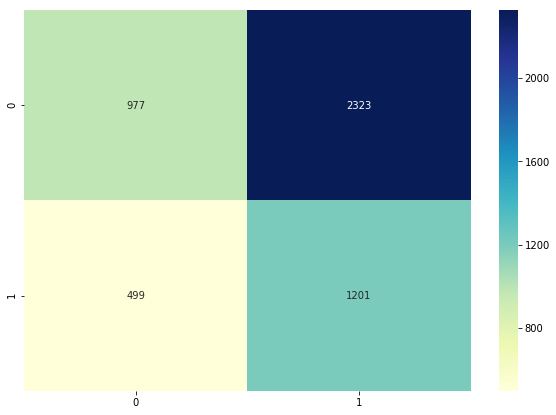

In [27]:
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')